In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Load data
job_offers = pd.read_csv("job_offers_20250608_1907.csv")
job_skill_matches = pd.read_csv("job_skill_matches.csv")
study_skill_match_counts = pd.read_csv("study_skill_match_counts.csv")
job_skill_frequencies = pd.read_csv("job_skill_frequencies.csv")

# --- Helper: Convert all string data in DataFrames to lowercase ---
def to_lowercase(df):
    return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

job_offers = to_lowercase(job_offers)
job_skill_matches = to_lowercase(job_skill_matches)
study_skill_match_counts = to_lowercase(study_skill_match_counts)
job_skill_frequencies = to_lowercase(job_skill_frequencies)

# --- Merge job offers and skill matches ---
merged_df = pd.merge(
    job_offers,
    job_skill_matches,
    how="left",
    left_on=["title", "company"],
    right_on=["job_title", "company"]
)
merged_df.drop(columns=["job_title"], inplace=True)
# remove 'wykształcenie wyższe' from requirements
merged_df["requirements"] = merged_df["requirements"].str.replace("wykształcenie wyższe", "", regex=False)

# --- Translation dictionary (all lowercase) ---
translation_dict = {
    "język angielski": "english language",
    "sztuczna inteligencja": "artificial intelligence",
    "metody badawcze": "research methods",
    "effective communication in academic and professional context": "effective communication",
    "samodzielność": "independence",
    "komunikatywność": "communication skills",
    "umiejętność pracy w zespole": "teamwork",
    "analityczne myślenie": "analytical thinking",
    "zarządzanie projektami": "project management",
    "umiejętność rozwiązywania problemów": "problem-solving skills",
    "przywództwo": "leadership",
    "prezes": "ceo",
    "kierownik": "manager",
    "asystent": "assistant",
    "specjalista": "specialist",
    "starszy specjalista": "senior specialist",
    "młodszy specjalista": "junior specialist",
    "stażysta": "intern",
    "rozwój": "development",
    "nauczanie maszynowe": "machine learning",
    "analiza danych": "data analysis",
    "zarządzanie zespołem": "team management",
    "programowanie": "programming",
    "testowanie": "testing",
    "obsługa klienta": "customer service",
    "prezentacje": "presentations",
    "chmura": "cloud",
    "bazy danych": "databases",
    "konteneryzacja": "containerization",
    "zł": "",
    "–": "-",
    # skills
    "sql": "sql", "r": "r", "python": "python", "java": "java",
    "spring": "spring", "docker": "docker", "azure": "azure", "aws": "aws",
    "frontend": "frontend", "backend": "backend", "devops": "devops"
}

# Apply translation to appropriate columns
columns_to_translate = ["employment_type", "location", "work_mode", "contract_types", "work_schedule"]
for col in columns_to_translate:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].replace(translation_dict, regex=True)

# Translate skills in other datasets
study_skill_match_counts["study_skill"] = study_skill_match_counts["study_skill"].replace(translation_dict, regex=True)
job_skill_frequencies["job_skill"] = job_skill_frequencies["job_skill"].replace(translation_dict, regex=True)

# --- Salary Parsing and Analysis ---
def safe_extract_salary_range(s):
    try:
        s = s.replace(" ", "").replace("zł", "").strip()
        if "-" in s:
            parts = s.split("-")
            return float(parts[0]), float(parts[1])
        elif s:
            val = float(s)
            return val, val
    except:
        return np.nan, np.nan

# Extract min/max/avg salary
salary_bounds = merged_df["salary_ranges"].dropna().apply(safe_extract_salary_range)
salary_df = pd.DataFrame(salary_bounds.tolist(), columns=["salary_min", "salary_max"])
merged_df.loc[salary_df.index, "salary_min"] = salary_df["salary_min"]
merged_df.loc[salary_df.index, "salary_max"] = salary_df["salary_max"]
merged_df["salary_avg"] = merged_df[["salary_min", "salary_max"]].mean(axis=1)


C:\Users\dabro\AppData\Local\Temp\ipykernel_23864\865099657.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


C:\Users\dabro\AppData\Local\Temp\ipykernel_23864\1640665644.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["employment_type_clean"] = filtered_df["employment_type"].replace(employment_map)
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

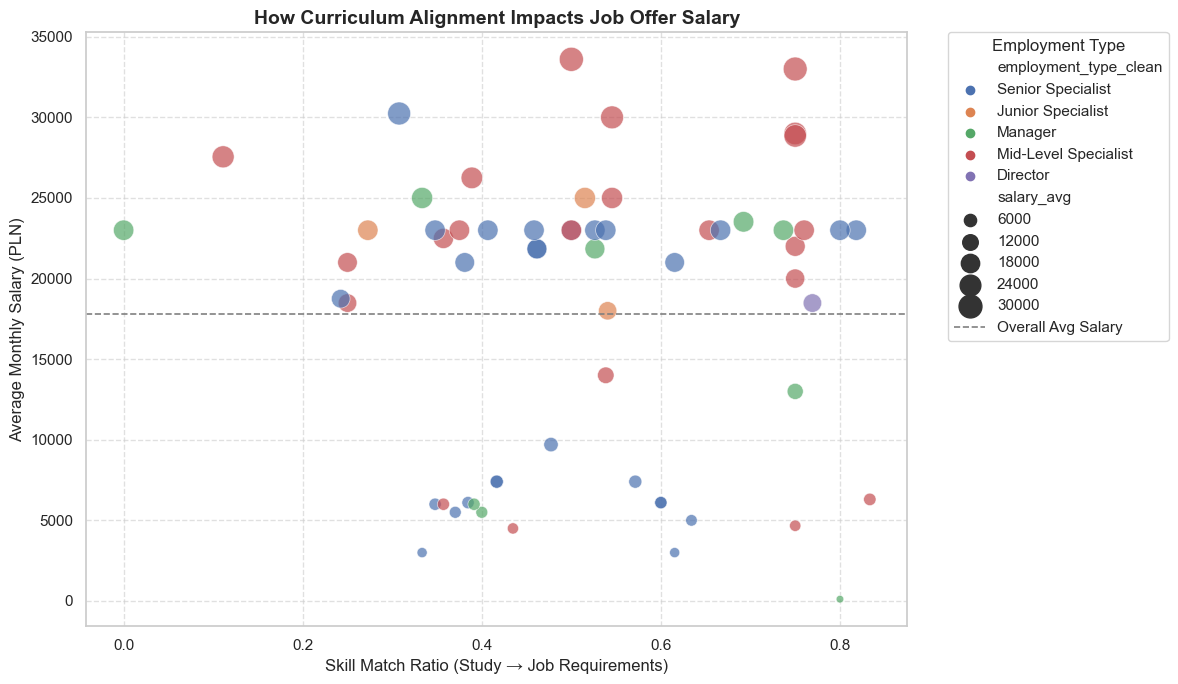

In [69]:
# Improve the scatterplot with additional annotations, better styling, and clarity

# Filter out rows with missing data to improve clarity
filtered_df = merged_df.dropna(subset=["match_ratio", "salary_avg", "employment_type"])

# Simplify and normalize employment type values
employment_map = {
    "junior specialist (junior)": "Junior Specialist",
    "specialist (mid / regular)": "Mid-Level Specialist",
    "senior specialist (senior)": "Senior Specialist",
    "manager / supervisor": "Manager",
    "team manager": "Manager",
    "manager / supervisor, team manager": "Manager",
    "senior specialist (senior), expert": "Senior Specialist",
    "specialist (mid / regular), junior specialist (junior)": "Mid-Level Specialist",
    "specialist (mid / regular), senior specialist (senior)": "Senior Specialist",
    "trainee": "Intern",
    "trainee, assistant": "Intern",
    "assistant": "Junior Specialist",
    "expert": "Senior Specialist",
    "director": "Director",
    "director, team manager": "Director",
    "director, prezes": "Director",
    "prezes": "Director",
    "entry level & blue collar": "Other",
    "pracownik fizyczny": "Other"
}

# Apply this mapping
filtered_df["employment_type_clean"] = filtered_df["employment_type"].replace(employment_map)

# Replot with cleaned categories
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=filtered_df,
    x="match_ratio",
    y="salary_avg",
    hue="employment_type_clean",
    size="salary_avg",
    sizes=(30, 300),
    alpha=0.7,
    edgecolor="w",
    linewidth=0.5
)

plt.title("How Curriculum Alignment Impacts Job Offer Salary", fontsize=14, weight="bold")
plt.xlabel("Skill Match Ratio (Study → Job Requirements)")
plt.ylabel("Average Monthly Salary (PLN)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.axhline(filtered_df["salary_avg"].mean(), color="gray", linestyle="dashed", linewidth=1.2, label="Overall Avg Salary")
plt.legend(title="Employment Type", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

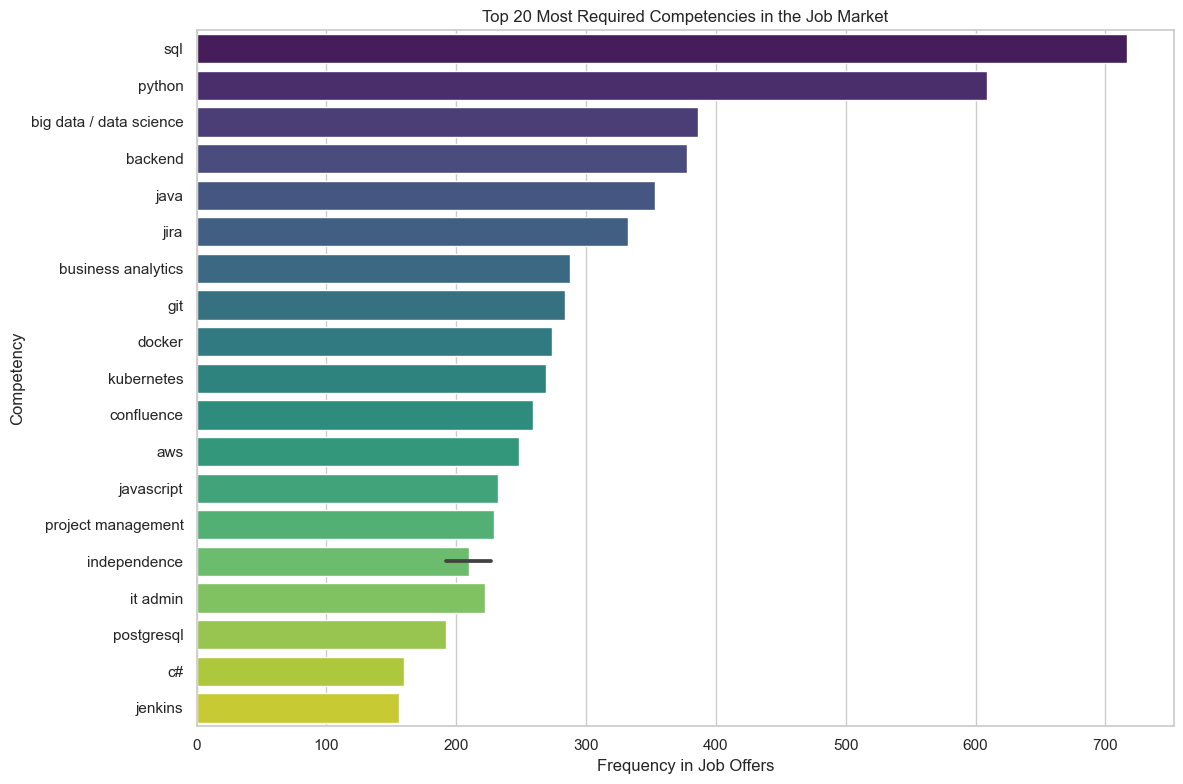

In [75]:
# --- 4.1 Job Market Competencies ---
top20_job_skills = job_skill_frequencies.sort_values(by="frequency", ascending=False).head(21)
top20_job_skills = top20_job_skills[top20_job_skills["job_skill"] != "wykształcenie wyższe"].head(20)
plt.figure(figsize=(12, 8))
sns.barplot(data=top20_job_skills, y="job_skill", x="frequency", palette="viridis")
plt.title("Top 20 Most Required Competencies in the Job Market")
plt.xlabel("Frequency in Job Offers")
plt.ylabel("Competency")
plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

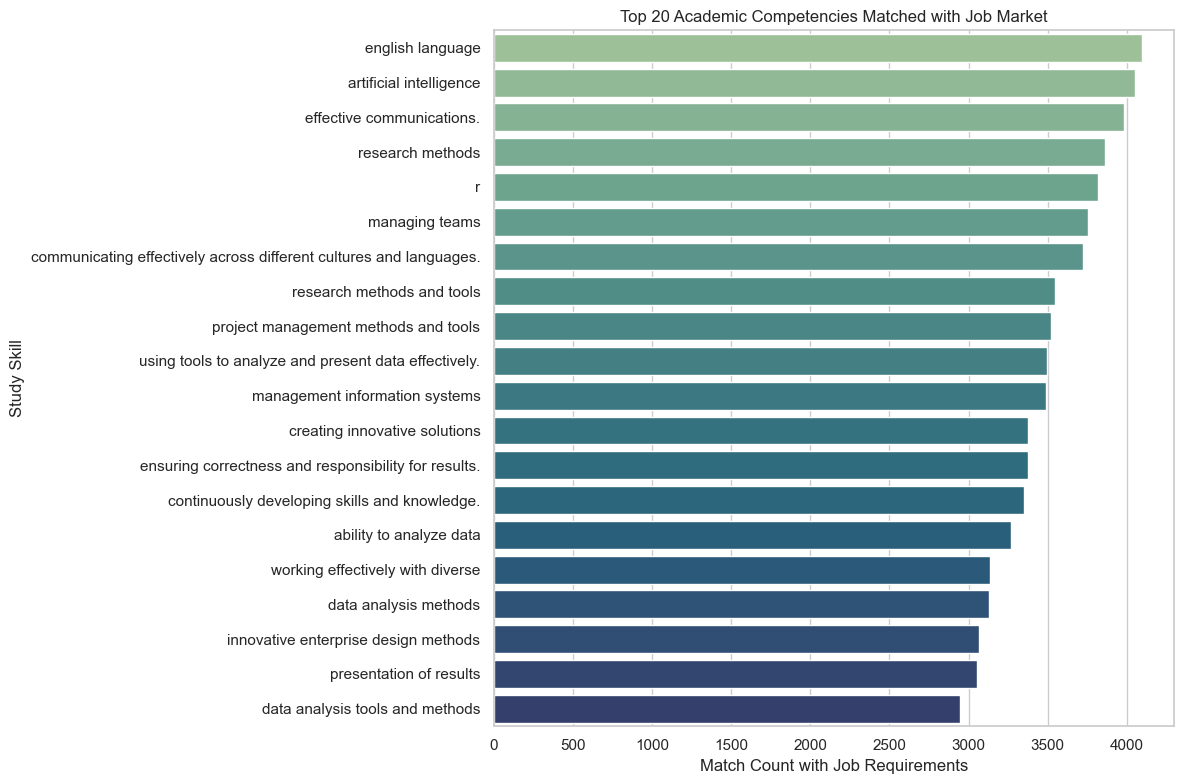

In [78]:
# Add missing Polish → English translations from the chart
study_translation_update = {
    "metody i narzędzia badawcze": "research methods and tools",
    "metody i narzędzia zarządzania projektami": "project management methods and tools",
    "systemy informatyczne zarządzania": "management information systems",
    "tworzenie innowacyjnych rozwiązań, kreatywne myślenie, projektowanie produktów.": "creating innovative solutions",
    "metody analizy danych": "data analysis methods",
    "metody projektowania innowacyjnego przedsiębiorstwa": "innovative enterprise design methods",
    "prezentacja wyników, argumentacja, negocjacje, komunikacja międzykulturowa.": "presentation of results",
    "metody i narzędzia analizy danych": "data analysis tools and methods"
}

# Apply translations
study_skill_match_counts["study_skill"] = study_skill_match_counts["study_skill"].replace(study_translation_update, regex=False)

# Re-plot with updated labels
top20_study_skills = study_skill_match_counts.sort_values(by="match_count", ascending=False).head(20)
# Split labels at the first comma for cleaner display
def simplify_label(label):
    return label.split(",")[0].strip() if isinstance(label, str) else label

# Apply simplification
study_skill_match_counts["study_skill"] = study_skill_match_counts["study_skill"].apply(simplify_label)

# Re-select and re-plot the top 20
top20_study_skills = study_skill_match_counts.sort_values(by="match_count", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top20_study_skills, y="study_skill", x="match_count", palette="crest")
plt.title("Top 20 Academic Competencies Matched with Job Market")
plt.xlabel("Match Count with Job Requirements")
plt.ylabel("Study Skill")
plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

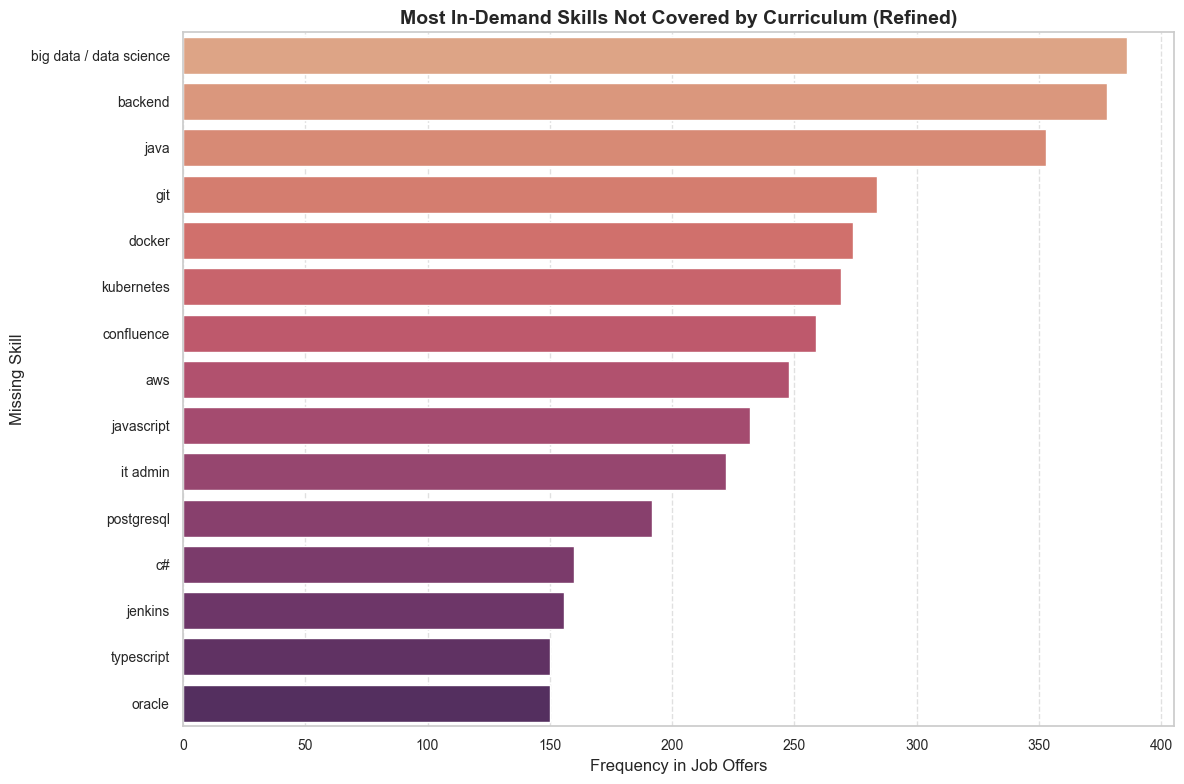

In [85]:
# --- 4.3 Competency Gaps ---
job_skills_set = set(job_skill_frequencies['job_skill'].str.lower())
study_skills_set = set(study_skill_match_counts['study_skill'].str.lower())
gap_skills = job_skills_set - study_skills_set
gap_freqs = job_skill_frequencies[job_skill_frequencies['job_skill'].str.lower().isin(gap_skills)]
# Drop 'wykształcenie wyższe' if present
# Remove specific skills that the user confirmed are covered by studies
skills_to_remove = {
    "jira",
    "business analytics",
    "wykształcenie wyższe", 
    "project management",
    "wykształcenie wyższe", 
    "independence"
}

# Re-filter the top gap skills
filtered_gap_freqs = gap_freqs[~gap_freqs["job_skill"].str.lower().isin(skills_to_remove)]
top_filtered_gap_skills = filtered_gap_freqs.sort_values(by="frequency", ascending=False).head(15)

# Beautify the chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_filtered_gap_skills,
    y="job_skill",
    x="frequency",
    palette="flare"
)
plt.title("Most In-Demand Skills Not Covered by Curriculum (Refined)", fontsize=14, weight='bold')
plt.xlabel("Frequency in Job Offers", fontsize=12)
plt.ylabel("Missing Skill", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

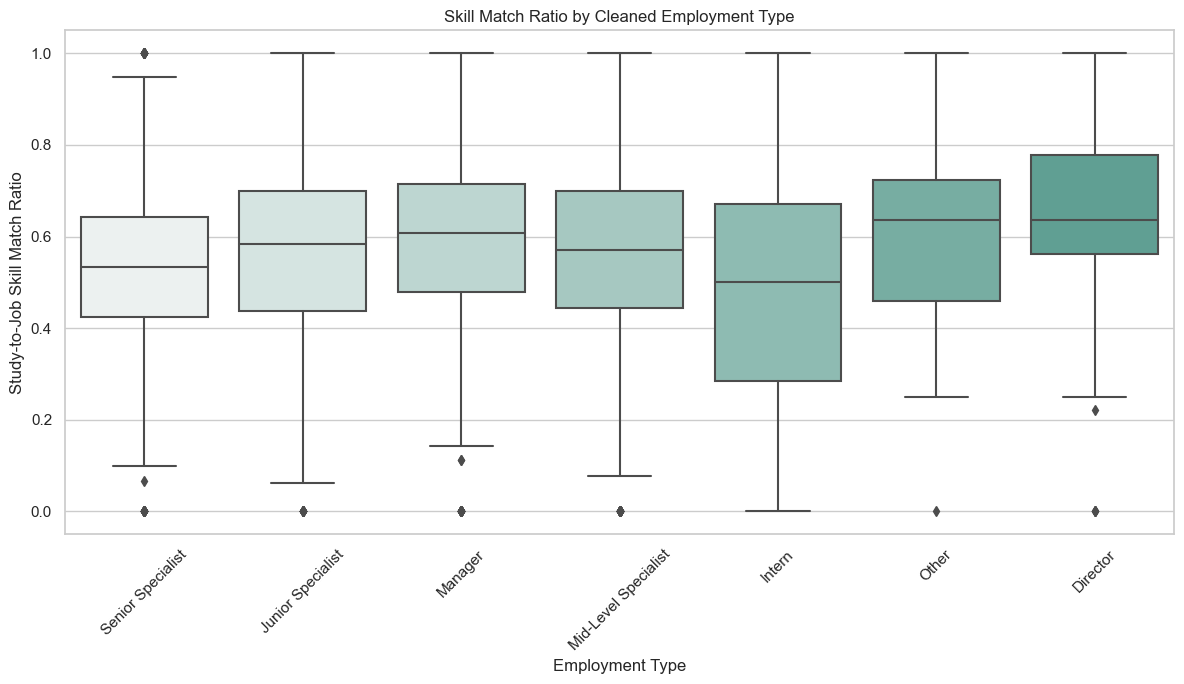

C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


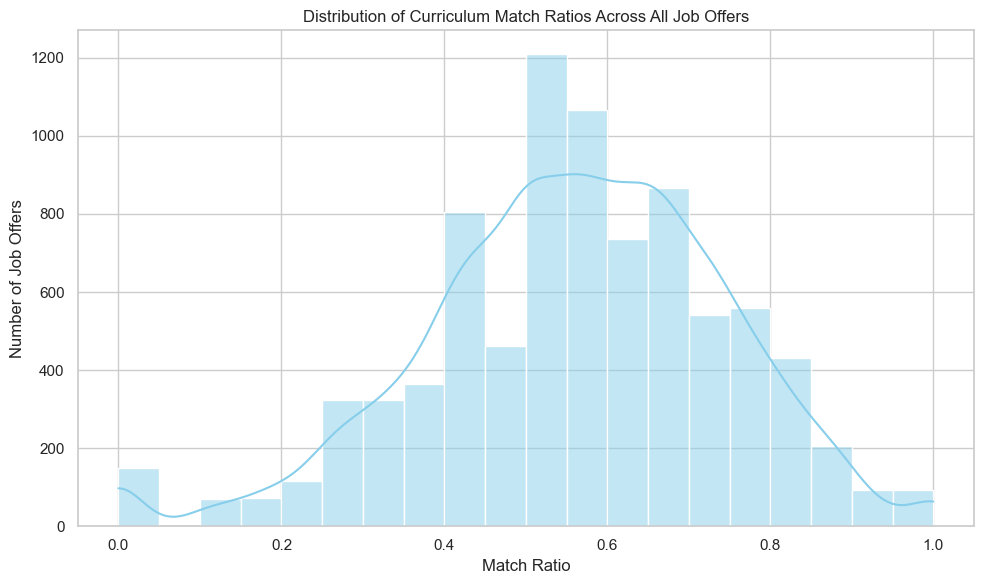

In [ ]:
# Merge similar employment type labels and clean them
employment_map = {
    "junior specialist (junior)": "Junior Specialist",
    "assistant, junior specialist (junior)": "Junior Specialist",
    "specialist (mid / regular)": "Mid-Level Specialist",
    "specialist (mid / regular), junior specialist (junior)": "Mid-Level Specialist",
    "specialist (mid / regular), senior specialist (senior)": "Senior Specialist",
    "senior specialist (senior)": "Senior Specialist",
    "senior specialist (senior), expert": "Senior Specialist",
    "expert": "Senior Specialist",
    "manager / supervisor": "Manager",
    "team manager": "Manager",
    "manager / supervisor, team manager": "Manager",
    "director": "Director",
    "director, team manager": "Director",
    "director, ceo": "Director",
    "ceo": "Director",
    "pracownik fizyczny": "Other",
    "entry level & blue collar": "Other",
    "trainee": "Intern",
    "trainee, assistant": "Intern",
    "assistant": "Junior Specialist",
    "executive": "Director"
}

# Apply mapping
merged_df["employment_type_clean"] = merged_df["employment_type"].replace(employment_map)

# --- 4.5 Curriculum Match Insights (Cleaned) ---
plt.figure(figsize=(12, 7))
sns.boxplot(data=merged_df, x="employment_type_clean", y="match_ratio", palette="light:#5A9")
plt.title("Skill Match Ratio by Cleaned Employment Type")
plt.xlabel("Employment Type")
plt.ylabel("Study-to-Job Skill Match Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Shapiro-Wilk test statistic: 0.9857, p-value: 2.095e-28
Distribution is not normal (reject H0)
Median match ratio: 0.571
Average match ratio: 0.559


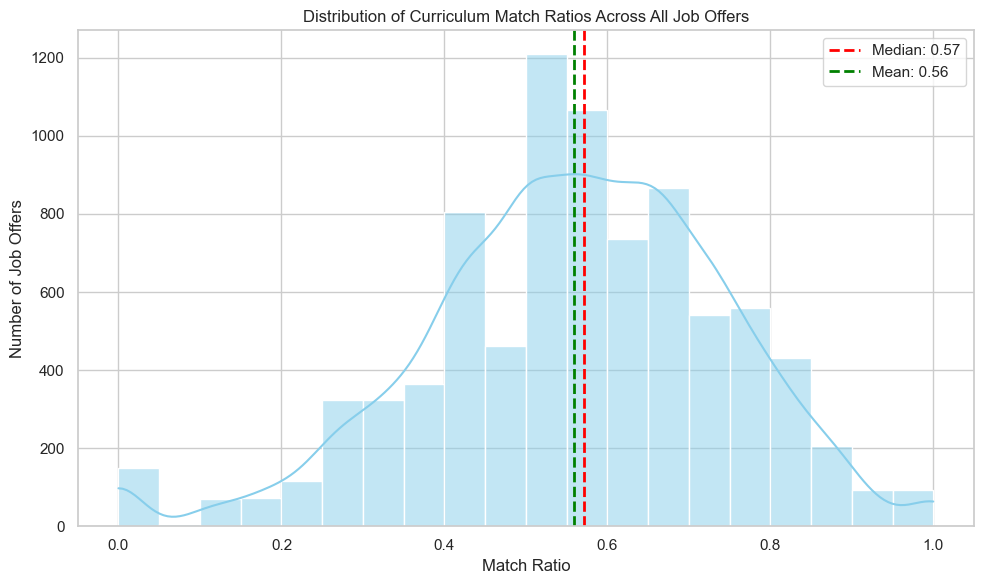

In [81]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for normality
stat, p_value = shapiro(merged_df['match_ratio'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value > 0.05:
    print("Distribution looks normal (fail to reject H0)")
else:
    print("Distribution is not normal (reject H0)")

median = merged_df['match_ratio'].median()
mean = merged_df['match_ratio'].mean()
print(f"Median match ratio: {median:.3f}")
print(f"Average match ratio: {mean:.3f}")

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['match_ratio'].dropna(), bins=20, kde=True, color="skyblue")
plt.axvline(median, color='red', linestyle='dashed', linewidth=2, label=f"Median: {median:.2f}")
plt.axvline(mean, color='green', linestyle='dashed', linewidth=2, label=f"Mean: {mean:.2f}")
plt.title("Distribution of Curriculum Match Ratios Across All Job Offers")
plt.xlabel("Match Ratio")
plt.ylabel("Number of Job Offers")
plt.legend()
plt.tight_layout()
plt.show()

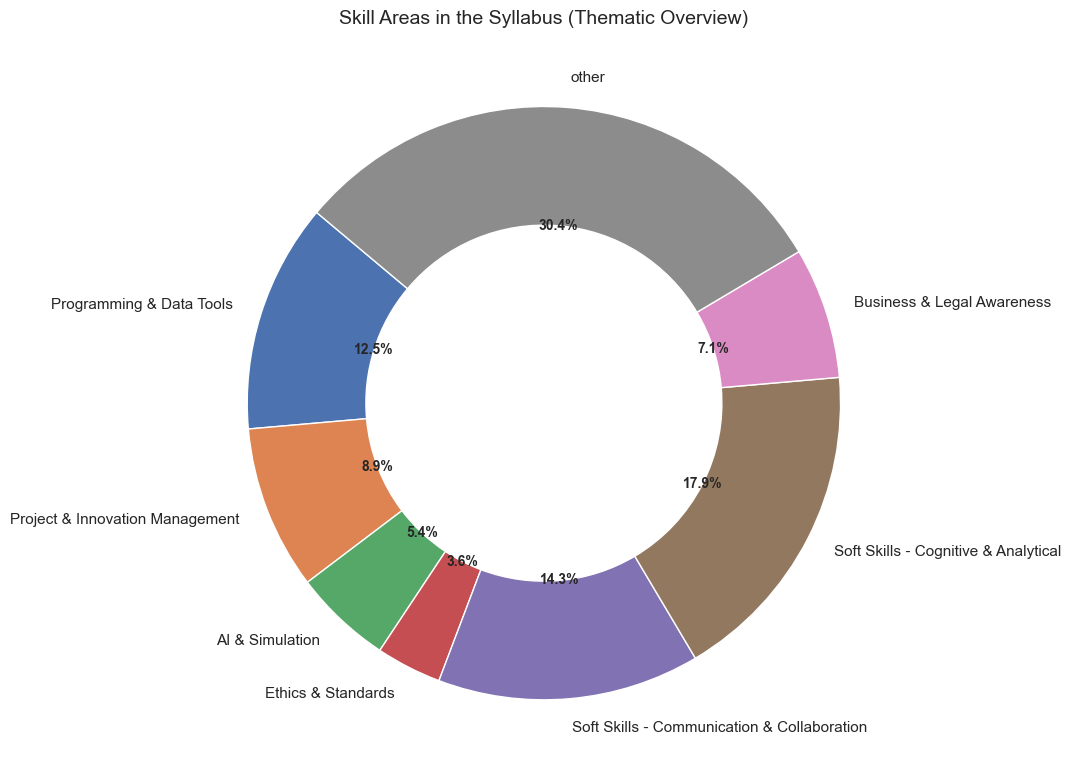

In [88]:
import matplotlib.pyplot as plt

# High-level categories and counts based on a more thematic understanding of the data
skill_categories = {
    "Programming & Data Tools": 7,  # Python, R, SQL, MATLAB, Python libs, etc.
    "Project & Innovation Management": 5,  # Project tools, MS Project, Innovation methods
    "AI & Simulation": 3,  # AI, simulation tools
    "Ethics & Standards": 2,  # Ethics, normative systems
    "Soft Skills - Communication & Collaboration": 8,  # Communication, leadership, teamwork
    "Soft Skills - Cognitive & Analytical": 10,  # Critical thinking, problem solving, research, etc.
    "Business & Legal Awareness": 4,  # Accounting, law, regulatory knowledge
    "other": 56-39
}

# Plotting a donut chart
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(skill_categories.values(), labels=skill_categories.keys(),
                                  autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))

ax.set_title("Skill Areas in the Syllabus (Thematic Overview)", fontsize=14)
plt.setp(autotexts, size=10, weight="bold")
plt.tight_layout()
plt.show()


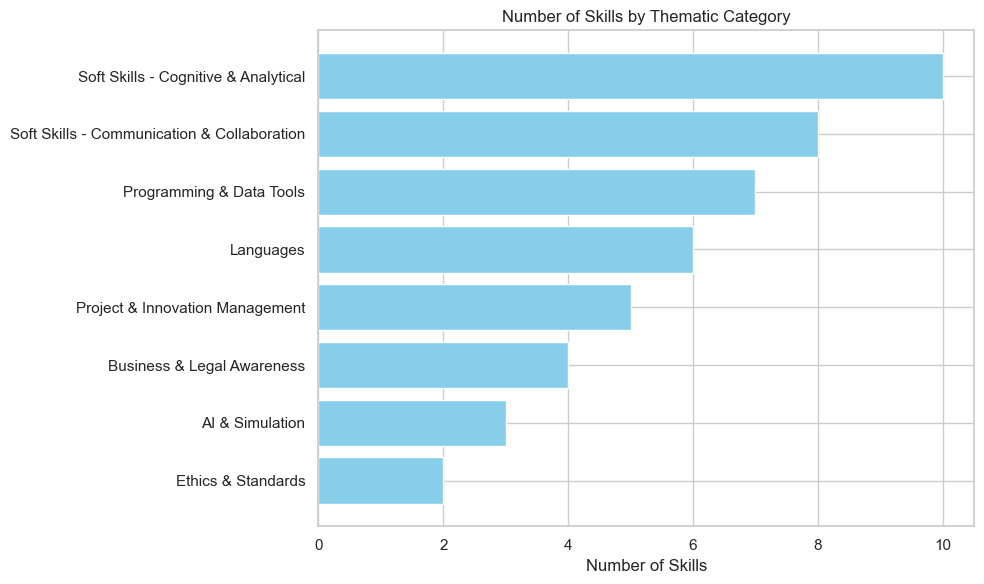

In [87]:
import pandas as pd

# Create a DataFrame from the thematic breakdown
skill_counts_df = pd.DataFrame({
    "Category": list(skill_categories.keys()),
    "Count": list(skill_categories.values())
}).sort_values(by="Count", ascending=False)

# Display the table to the user

# Plotting a horizontal bar chart for clearer readability
plt.figure(figsize=(10, 6))
plt.barh(skill_counts_df["Category"], skill_counts_df["Count"], color='skyblue')
plt.xlabel("Number of Skills")
plt.title("Number of Skills by Thematic Category")
plt.gca().invert_yaxis()  # Highest count on top
plt.tight_layout()
plt.show()


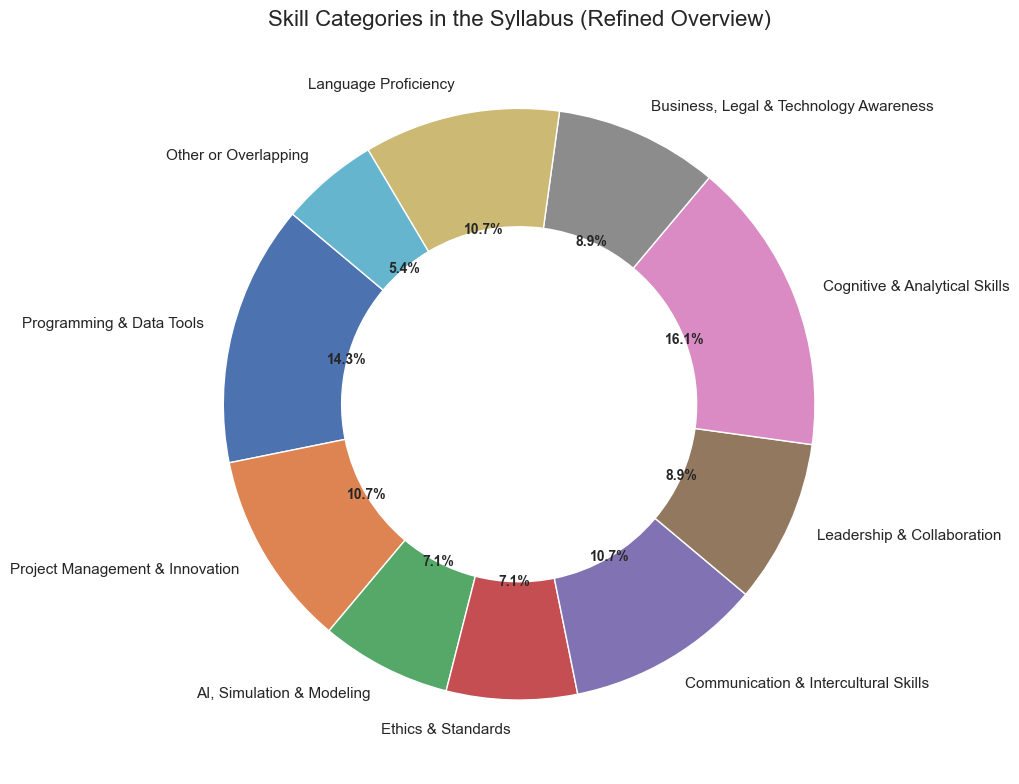

In [89]:
import matplotlib.pyplot as plt

# Updated skill categories based on the uploaded file
refined_skill_categories = {
    "Programming & Data Tools": 8,  # Python, R, SQL, MATLAB, Python libraries, etc.
    "Project Management & Innovation": 6,  # MS Project, innovation methods, project tools
    "AI, Simulation & Modeling": 4,  # AI, simulation tools, modeling
    "Ethics & Standards": 4,  # Ethics, ethical AI, normative systems
    "Communication & Intercultural Skills": 6,  # Communication, intercultural skills
    "Leadership & Collaboration": 5,  # Leadership, teamwork, negotiation
    "Cognitive & Analytical Skills": 9,  # Critical thinking, research, problem solving, data viz
    "Business, Legal & Technology Awareness": 5,  # Accounting, law, cloud, regulatory
    "Language Proficiency": 6,  # Various languages
    "Other or Overlapping": 3  # Miscellaneous not fitting cleanly elsewhere
}

# Plotting the improved donut chart
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(refined_skill_categories.values(), labels=refined_skill_categories.keys(),
                                  autopct='%1.1f%%', startangle=140,
                                  wedgeprops=dict(width=0.4, edgecolor='w'))

ax.set_title("Skill Categories in the Syllabus (Refined Overview)", fontsize=16)
plt.setp(autotexts, size=10, weight="bold")
plt.tight_layout()
plt.show()
